# Fine tune DNN parameters

### Note that you have to execute the first 4 cells and then you can execute each part of this notebook separately

This notebook's aim is to find appropriate parameters for the implemented deep neural network which optimize training speed and Sharpe ratio. We experiment with the first 7 months of data (6 months for training and 1 month for testing) as this will be the rolling window used in the final strategy.

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload


In [2]:
# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())

In [3]:
daily = pd.read_csv("Targets/daily_crsp_sanitized.csv", nrows = 2000000)
daily['date'] = pd.to_datetime(daily['date'], format = "%Y-%m-%d")
daily = daily[daily['date'] >= '2000-01-31'] # Start at the end of January to align with predictors data
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218
158484,2000-01-31,25,62770,6711,0,0.041045,0.025218
158485,2000-01-31,29,59184,2082,0,0.011236,0.025218
158486,2000-01-31,33,59248,2082,0,0.034667,0.025218
...,...,...,...,...,...,...,...
1999995,2000-12-13,16265,86321,6310,0,0.057471,-0.008161
1999996,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161
1999997,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161
1999998,2000-12-13,16268,86339,4899,0,0.009456,-0.008161


In [19]:
daily.describe()

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
count,1841518,1.841518e+06,1.841518e+06,1.841518e+06,1841518.0,1.841518e+06,1.841518e+06
mean,2000-07-06 21:08:56.728068480,1.738957e+04,7.050770e+04,5.110886e+03,0.0,-1.235500e-04,1.124562e-04
min,2000-01-31 00:00:00,5.000000e+00,1.000100e+04,0.000000e+00,0.0,-1.000000e+00,-5.827800e-02
25%,2000-04-18 00:00:00,1.129900e+04,6.839800e+04,3.621000e+03,0.0,-2.142900e-02,-8.207000e-03
50%,2000-07-07 00:00:00,1.562500e+04,8.027600e+04,5.149000e+03,0.0,0.000000e+00,-2.280000e-04
75%,2000-09-25 00:00:00,2.167800e+04,8.540500e+04,6.726000e+03,0.0,1.718200e-02,8.130000e-03
max,2000-12-13 00:00:00,5.701800e+04,9.331600e+04,9.990000e+03,0.0,4.045455e+00,4.763900e-02
std,NaN,9.527787e+03,2.312819e+04,1.916887e+03,0.0,5.981557e-02,1.372986e-02


In [4]:
# Remove outliers
# Compute quantile thresholds for winsorization
lower_quantile = daily['DlyRet'].quantile(0.005)
upper_quantile = daily['DlyRet'].quantile(0.995)


# Identify outliers for reporting
outliers = (daily['DlyRet'] < lower_quantile) | (daily['DlyRet'] > upper_quantile)
print(f"Number of daily return outliers: {outliers.sum():,}")

# Winsorize: cap values at the quantile thresholds
daily['DlyRet'] = daily['DlyRet'].clip(lower=lower_quantile, upper=upper_quantile)
daily.describe()

Number of daily return outliers: 18,415


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
count,1841518,1.841518e+06,1.841518e+06,1.841518e+06,1841518.0,1.841518e+06,1.841518e+06
mean,2000-07-06 21:08:56.728068480,1.738957e+04,7.050770e+04,5.110886e+03,0.0,-4.055828e-04,1.124562e-04
min,2000-01-31 00:00:00,5.000000e+00,1.000100e+04,0.000000e+00,0.0,-1.907121e-01,-5.827800e-02
25%,2000-04-18 00:00:00,1.129900e+04,6.839800e+04,3.621000e+03,0.0,-2.142900e-02,-8.207000e-03
50%,2000-07-07 00:00:00,1.562500e+04,8.027600e+04,5.149000e+03,0.0,0.000000e+00,-2.280000e-04
75%,2000-09-25 00:00:00,2.167800e+04,8.540500e+04,6.726000e+03,0.0,1.718200e-02,8.130000e-03
max,2000-12-13 00:00:00,5.701800e+04,9.331600e+04,9.990000e+03,0.0,2.490120e-01,4.763900e-02
std,NaN,9.527787e+03,2.312819e+04,1.916887e+03,0.0,5.304362e-02,1.372986e-02


In [5]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

158482     2000-01
166811     2000-02
333239     2000-03
524367     2000-04
682344     2000-05
865365     2000-06
1048421    2000-07
1214853    2000-08
1407308    2000-09
1573891    2000-10
1756726    2000-11
1930059    2000-12
Name: year_month, dtype: period[M]

In [6]:
reload(utils)
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [6]:
train_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
158482,2000-01-31,15580,786,-0.068182,0.025218,0.000000,0.000000,0.000000,0.000000
158483,2000-01-31,14593,399,0.020910,0.025218,0.000000,0.000000,0.000000,0.000000
158484,2000-01-31,62770,812,0.041045,0.025218,0.000000,0.000000,0.000000,0.000000
158485,2000-01-31,59184,110,0.011236,0.025218,0.000000,0.000000,0.000000,0.000000
158486,2000-01-31,59248,110,0.034667,0.025218,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.008465,-0.012987,0.005534,0.004883,0.003759
1048417,2000-06-30,79191,43,0.018018,0.008465,0.037383,-0.007211,-0.003063,-0.005090
1048418,2000-06-30,78671,544,-0.070423,0.008465,0.105058,-0.005470,-0.004885,-0.003756
1048419,2000-06-30,17337,316,0.000000,0.008465,-0.032967,-0.009523,-0.001953,-0.004991


In [7]:
test_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
1048421,2000-07-03,15580,770,0.011494,0.010271,0.000000,0.000000,0.000000,0.000000
1048422,2000-07-03,14593,388,0.017900,0.010271,0.000000,0.000000,0.000000,0.000000
1048423,2000-07-03,62770,796,0.055556,0.010271,0.000000,0.000000,0.000000,0.000000
1048424,2000-07-03,59184,108,0.020921,0.010271,0.000000,0.000000,0.000000,0.000000
1048425,2000-07-03,59248,108,0.020661,0.010271,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1214848,2000-07-31,15912,802,0.013514,0.007705,-0.013333,-0.002595,-0.000048,-0.000048
1214849,2000-07-31,79191,41,0.013953,0.007705,-0.027149,-0.009405,-0.002302,-0.002302
1214850,2000-07-31,78671,529,0.012007,0.007705,-0.013536,0.002401,0.005514,0.005514
1214851,2000-07-31,17337,307,0.012500,0.007705,0.012658,-0.011365,-0.004435,-0.004435


In [22]:
# Let us first normalize the returns before training the model
means_train = {}
stds_train = {}
for col in features:
    mean = train_df[col].mean()
    std = train_df[col].std()
    train_df[col] = (train_df[col] - mean) / (std + 10e-8)
    means_train[col] = mean
    stds_train[col] = std

train_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
158482,2000-01-31,15580,786,-0.068182,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158483,2000-01-31,14593,399,0.020910,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158484,2000-01-31,62770,812,0.041045,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158485,2000-01-31,59184,110,0.011236,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158486,2000-01-31,59248,110,0.034667,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
...,...,...,...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.497506,-0.226652,0.271069,0.290267,0.232598
1048417,2000-06-30,79191,43,0.018018,0.497506,0.610218,-0.442468,-0.285459,-0.478276
1048418,2000-06-30,78671,544,-0.070423,0.497506,1.734601,-0.344966,-0.417532,-0.371165
1048419,2000-06-30,17337,316,0.000000,0.497506,-0.558608,-0.571880,-0.205093,-0.470373


In [23]:
# Let us first normalize the returns before training the model
means_test = {}
stds_test = {}
for col in features:
    mean = test_df[col].mean()
    std = test_df[col].std()
    test_df[col] = (test_df[col] - mean) / (std + 10e-8)
    means_test[col] = mean
    stds_test[col] = std

train_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
158482,2000-01-31,15580,786,-0.068182,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158483,2000-01-31,14593,399,0.020910,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158484,2000-01-31,62770,812,0.041045,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158485,2000-01-31,59184,110,0.011236,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
158486,2000-01-31,59248,110,0.034667,1.577661,-0.010880,-0.038752,-0.063558,-0.069385
...,...,...,...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.497506,-0.226652,0.271069,0.290267,0.232598
1048417,2000-06-30,79191,43,0.018018,0.497506,0.610218,-0.442468,-0.285459,-0.478276
1048418,2000-06-30,78671,544,-0.070423,0.497506,1.734601,-0.344966,-0.417532,-0.371165
1048419,2000-06-30,17337,316,0.000000,0.497506,-0.558608,-0.571880,-0.205093,-0.470373


## First run: 50 epochs, default learning rate, 5 days of past returns 

In [ ]:
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions = utils.train_DNN(train_df, test_df, features, cat_features, epochs=20)

Starting training with 435 train batches, 41 test batches


Training:   5%|█▋                                | 1/20 [00:15<04:55, 15.57s/it]

Epoch 1/20, Loss: 0.0029, Train Sharpe: 0.0203, Test Sharpe: 0.0123


Training:  15%|█████                             | 3/20 [00:48<04:33, 16.07s/it]

Epoch 3/20, Loss: -0.0384, Train Sharpe: 0.0544, Test Sharpe: 0.0604


Training:  25%|████████▌                         | 5/20 [01:17<03:47, 15.19s/it]

Epoch 5/20, Loss: -0.0534, Train Sharpe: 0.0655, Test Sharpe: 0.0623


Training:  35%|███████████▉                      | 7/20 [01:45<03:07, 14.41s/it]

Epoch 7/20, Loss: -0.0600, Train Sharpe: 0.0718, Test Sharpe: 0.0657


Training:  45%|███████████████▎                  | 9/20 [02:12<02:33, 13.99s/it]

Epoch 9/20, Loss: -0.0650, Train Sharpe: 0.0774, Test Sharpe: 0.0673


Training:  55%|██████████████████▏              | 11/20 [02:41<02:08, 14.25s/it]

Epoch 11/20, Loss: -0.0694, Train Sharpe: 0.0845, Test Sharpe: 0.0686


Training:  60%|███████████████████▊             | 12/20 [03:03<02:13, 16.65s/it]

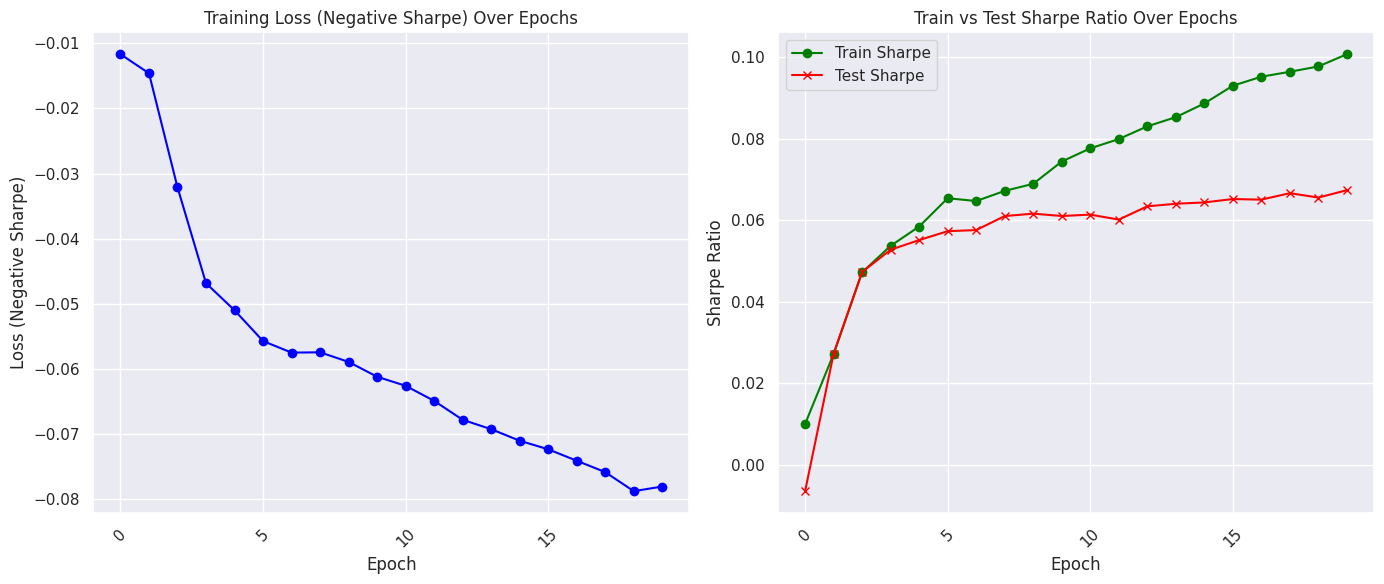

In [9]:
reload(utils)
epochs = 20
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

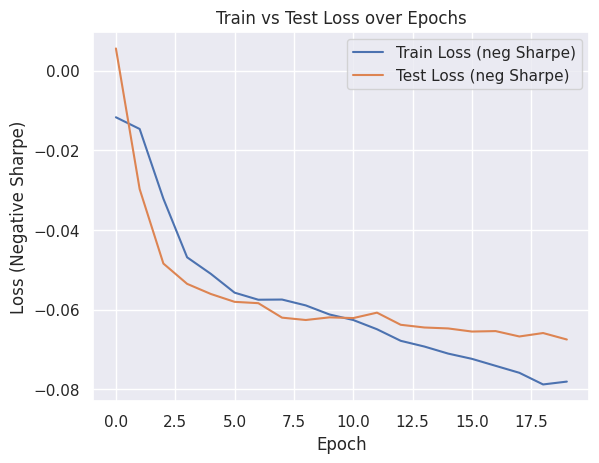

In [10]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

In [11]:
raw_predictions

0          5.114805
1          1.840788
2          2.407640
3          0.606234
4          0.606234
            ...    
166427     6.314581
166428    16.004969
166429    16.351252
166430   -15.221357
166431    -8.709176
Length: 166432, dtype: float32

In [12]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / e_x.sum()

test_df['raw_predictions'] = raw_predictions.values 
test_df['weight'] = test_df.groupby('date')['raw_predictions'].transform(softmax)
test_df['weight']

1048421    9.058988e-15
1048422    3.429200e-16
1048423    6.044663e-16
1048424    9.977752e-17
1048425    9.977752e-17
               ...     
1214848    6.618566e-18
1214849    1.069658e-13
1214850    1.512285e-13
1214851    2.936453e-27
1214852    1.977101e-24
Name: weight, Length: 166432, dtype: float32

In [17]:
print(test_df['weight'].sum())

19.999998


In [29]:
# Let us first normalize the returns before training the model
for col in features:
    mean = means_test[col]
    std = stds_test[col]
    test_df[col] = test_df[col] * (std + 10e-8) + mean
    
test_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30,raw_predictions,weight
1048421,2000-07-03,15580,770,0.011494,0.010271,1.084202e-19,0.000000,0.000000,0.000000,16.464622,4.962392e-07
1048422,2000-07-03,14593,388,0.017900,0.010271,1.084202e-19,0.000000,0.000000,0.000000,15.691399,2.290257e-07
1048423,2000-07-03,62770,796,0.055556,0.010271,1.084202e-19,0.000000,0.000000,0.000000,18.180996,2.761230e-06
1048424,2000-07-03,59184,108,0.020921,0.010271,1.084202e-19,0.000000,0.000000,0.000000,18.676117,4.530341e-06
1048425,2000-07-03,59248,108,0.020661,0.010271,1.084202e-19,0.000000,0.000000,0.000000,18.676117,4.530341e-06
...,...,...,...,...,...,...,...,...,...,...,...
1214848,2000-07-31,15912,802,0.013514,0.007705,-1.333300e-02,-0.002595,-0.000048,-0.000048,21.025578,3.590613e-13
1214849,2000-07-31,79191,41,0.013953,0.007705,-2.714900e-02,-0.009405,-0.002302,-0.002302,14.621692,5.942877e-16
1214850,2000-07-31,78671,529,0.012007,0.007705,-1.353600e-02,0.002401,0.005514,0.005514,21.380653,5.121251e-13
1214851,2000-07-31,17337,307,0.012500,0.007705,1.265800e-02,-0.011365,-0.004435,-0.004435,12.102167,4.783875e-17


In [18]:
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet']
print(test_df['strategy_return'].sum())

-0.11940891111788092


In [14]:
#normalized = raw_predictions/raw_predictions.sum()
#type(normalized)
#test_df['raw_predictions'] = np.maximum(0, raw_predictions.values) 
#test_df['normalized'] = (
#    test_df['raw_predictions'].abs() / test_df.groupby('date')['raw_predictions'].transform('sum')
#)

#test_df['strategy_return'] = test_df['normalized'] * test_df['DlyRet']
mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
#test_df['DlyRet']
mean_daily_returns
#test_df['strat_return']

date
2000-07-03   -0.000667
2000-07-05   -0.023437
2000-07-06   -0.001353
2000-07-07    0.025085
2000-07-10    0.004287
2000-07-11   -0.009002
2000-07-12    0.005032
2000-07-13   -0.008591
2000-07-14    0.016336
2000-07-17    0.005702
2000-07-18   -0.070821
2000-07-19    0.023823
2000-07-20    0.002546
2000-07-21    0.014485
2000-07-24    0.012357
2000-07-25    0.020488
2000-07-26   -0.115375
2000-07-27    0.059839
2000-07-28   -0.024568
2000-07-31   -0.055573
Name: strategy_return, dtype: float64

In [15]:
sharpe = np.sqrt(20) * (mean_daily_returns.mean() / mean_daily_returns.std())
sharpe

np.float64(-0.6965104996723842)

<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

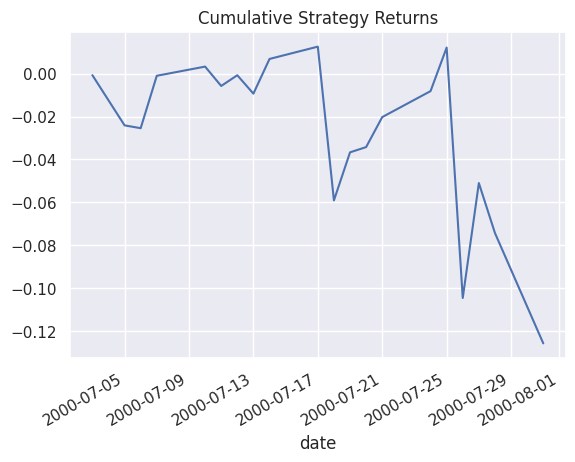

In [16]:
cumulative_returns = (1 + mean_daily_returns).cumprod() - 1
cumulative_returns.plot(title='Cumulative Strategy Returns')


<Axes: xlabel='date'>

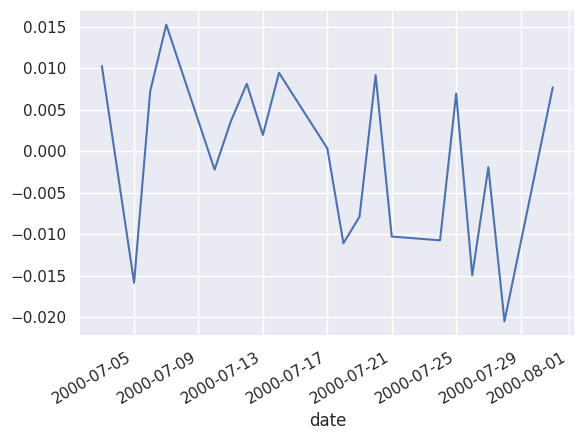

In [38]:
sp_ret = test_df.groupby('date')['sprtrn'].mean()
sp_ret.plot()

In [19]:
features

['DlyRet',
 'sprtrn',
 'DlyRet_lag1',
 'DlyRet_lag2',
 'DlyRet_lag3',
 'DlyRet_lag4',
 'DlyRet_lag5']

In [55]:
test_df['raw_predictions'].describe()

count    166432.000000
mean          2.862098
std           4.279382
min           0.000000
25%           0.000000
50%           0.000000
75%           5.118653
max          14.672428
Name: raw_predictions, dtype: float64

In [56]:
test_df['normalized'].describe()

count    166432.000000
mean          0.000120
std           0.000184
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000211
max           0.000860
Name: normalized, dtype: float64

In [57]:
test_df['strategy_return'].describe()

count    166432.000000
mean          0.000002
std           0.000003
min          -0.000000
25%          -0.000000
50%          -0.000000
75%           0.000006
max           0.000014
Name: strategy_return, dtype: float64

In [58]:
mean_daily_returns.describe()

count    20.000000
mean     -0.004011
std       0.000076
min      -0.004168
25%      -0.004040
50%      -0.003991
75%      -0.003970
max      -0.003904
Name: strat_return, dtype: float64

In [47]:
sharpe = 1/np.sqrt(250) * (mean_daily_returns.mean() / mean_daily_returns.std())
print(sharpe)

-3.3268181213301142


In [31]:
raw_predictions.head()

0    10.699574
1     7.722186
2     3.210319
3     7.319717
4     7.375998
dtype: float32

In [26]:
test_df.head()

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_lag2,DlyRet_lag3,DlyRet_lag4,DlyRet_lag5
1048421,2000-07-03,15580,770,0.011494,0.010271,0.0,0.0,0.0,0.0,0.0
1048422,2000-07-03,14593,388,0.017900,0.010271,0.0,0.0,0.0,0.0,0.0
1048423,2000-07-03,62770,796,0.055556,0.010271,0.0,0.0,0.0,0.0,0.0
1048424,2000-07-03,59184,108,0.020921,0.010271,0.0,0.0,0.0,0.0,0.0
1048425,2000-07-03,59248,108,0.020661,0.010271,0.0,0.0,0.0,0.0,0.0


In [32]:
strategy_returns = normalized.values * test_df['DlyRet']
strategy_returns.sum()

1048421   -4.757306e-07
1048422   -5.347080e-07
1048423   -6.899260e-07
1048424   -5.923796e-07
1048425   -5.895159e-07
               ...     
1214848   -4.796595e-07
1214849   -5.379454e-07
1214850   -4.887420e-07
1214851   -5.182757e-07
1214852   -4.915593e-07
Name: DlyRet, Length: 166432, dtype: float64

## Second run: increase learning rate, reduce epochs

It seems a high number of epochs isn't necessary for convergence. Actually, it reduces out of sample Sharpe ratio as it overfits the training data. We can train faster using less epochs and a higher learning rate. The above plots suggest 3 epochs is sufficient. However, since this is quite low, we first try with 10 and a faster learning rate of 0.01 instead of 0.001.

In [14]:
train_df

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_lag2,DlyRet_lag3,DlyRet_lag4,DlyRet_lag5
158482,2000-01-31,15580,786,-0.068182,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158483,2000-01-31,14593,399,0.020910,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158484,2000-01-31,62770,812,0.041045,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158485,2000-01-31,59184,110,0.011236,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
158486,2000-01-31,59248,110,0.034667,0.025218,0.000661,0.000679,0.000594,0.000624,0.000602
...,...,...,...,...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.008465,-0.012987,0.026667,0.000000,0.027397,0.000000
1048417,2000-06-30,79191,43,0.018018,0.008465,0.037383,0.023923,-0.066964,-0.062762,0.012712
1048418,2000-06-30,78671,544,-0.070423,0.008465,0.105058,-0.062044,-0.098684,-0.006536,-0.012903
1048419,2000-06-30,17337,316,0.000000,0.008465,-0.032967,0.000000,0.000000,0.011111,-0.032258


In [16]:
reload(utils)

<module 'DNN_utils' from '/home/mirko/user/ML/Project/DNN_utils.py'>

In [7]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df, test_df, features, cat_features, epochs=10, learning_rate=0.01)

Using 4 workers for data loading
PyTorch using 16 CPU threads
Using device: cpu
Starting CPU-optimized training...
Train batches: 435, Test batches: 41
Batch sizes - Train: 2048, Test: 4096
Effective batch size with accumulation: 4096
Model compiled for CPU optimization


Training:  10%|███▍                              | 1/10 [00:30<04:32, 30.29s/it]

Epoch 1/10, Loss: -0.0622, Train Sharpe: 0.1307, Test Sharpe: 0.1052, LR: 0.010000


Training:  40%|█████████████▌                    | 4/10 [01:17<01:56, 19.42s/it]

Epoch 4/10, Loss: -0.1629, Train Sharpe: 0.1767, Test Sharpe: 0.1048, LR: 0.010000


Training:  70%|███████████████████████▊          | 7/10 [02:01<00:51, 17.19s/it]

Epoch 7/10, Loss: -0.1782, Train Sharpe: 0.1901, Test Sharpe: 0.1088, LR: 0.010000


Training: 100%|█████████████████████████████████| 10/10 [02:49<00:00, 16.90s/it]

Epoch 10/10, Loss: -0.1834, Train Sharpe: 0.1965, Test Sharpe: 0.1181, LR: 0.010000
Training completed!
Best test Sharpe ratio: 0.1181


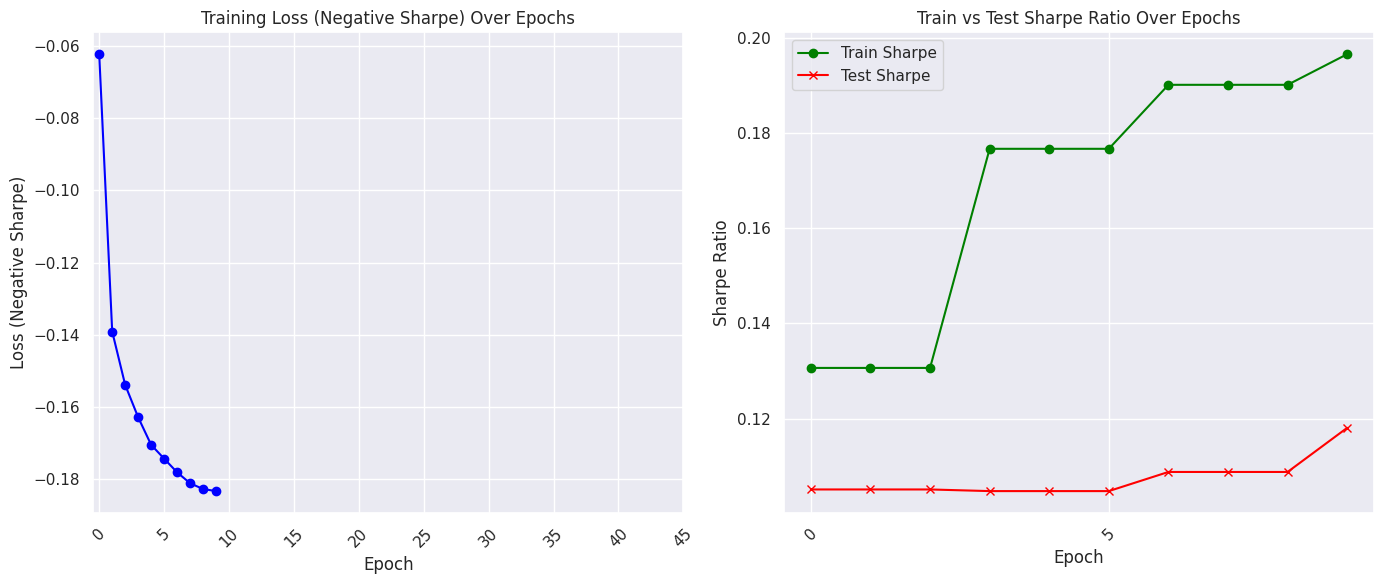

In [9]:
epochs=10
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

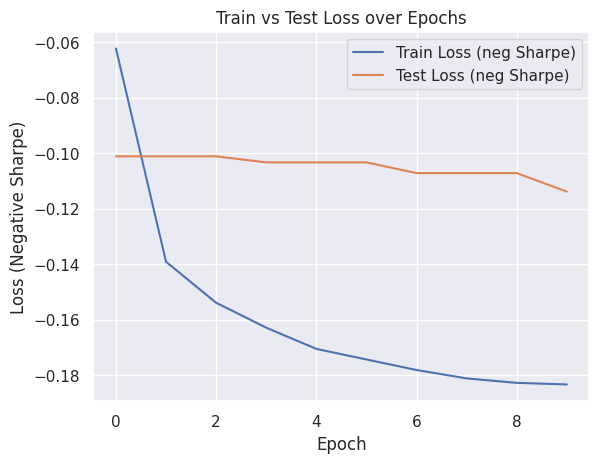

In [10]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

## Third run: use only 1 day lagged returns, not 1 to 5 and compare Sharpe ratio

It seems that increasing the learning rate by a factor of 10 before slightly lowered the maximal Sharpe ratio, so we'll keep it at 0.001 default value. 

In [7]:
reload(utils)
# Retrain with only 1 day lagged returns 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()
train_df_1, test_df_1, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1)

In [8]:
train_df_1

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1
158482,2000-01-31,15580,786,-0.068182,0.025218,0.000661
158483,2000-01-31,14593,399,0.020910,0.025218,0.000661
158484,2000-01-31,62770,812,0.041045,0.025218,0.000661
158485,2000-01-31,59184,110,0.011236,0.025218,0.000661
158486,2000-01-31,59248,110,0.034667,0.025218,0.000661
...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.008465,-0.012987
1048417,2000-06-30,79191,43,0.018018,0.008465,0.037383
1048418,2000-06-30,78671,544,-0.070423,0.008465,0.105058
1048419,2000-06-30,17337,316,0.000000,0.008465,-0.032967


In [9]:
test_df_1

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1
1048421,2000-07-03,15580,770,0.011494,0.010271,-0.001005
1048422,2000-07-03,14593,388,0.017900,0.010271,-0.001005
1048423,2000-07-03,62770,796,0.055556,0.010271,-0.001005
1048424,2000-07-03,59184,108,0.020921,0.010271,-0.001005
1048425,2000-07-03,59248,108,0.020661,0.010271,-0.001005
...,...,...,...,...,...,...
1214848,2000-07-31,15912,802,0.013514,0.007705,-0.013333
1214849,2000-07-31,79191,41,0.013953,0.007705,-0.027149
1214850,2000-07-31,78671,529,0.012007,0.007705,-0.013536
1214851,2000-07-31,17337,307,0.012500,0.007705,0.012658


In [11]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df_1, test_df_1, features, cat_features, epochs=10)

Using 4 workers for data loading
PyTorch using 16 CPU threads
Using device: cpu
Starting CPU-optimized training...
Train batches: 435, Test batches: 41
Batch sizes - Train: 2048, Test: 4096
Effective batch size with accumulation: 4096
Model compiled for CPU optimization


Training:  10%|███▍                              | 1/10 [00:44<06:38, 44.24s/it]

Epoch 1/10, Loss: -0.0150, Train Sharpe: 0.0247, Test Sharpe: -0.0078, LR: 0.001000


Training:  40%|█████████████▌                    | 4/10 [01:29<02:04, 20.77s/it]

Epoch 4/10, Loss: -0.0986, Train Sharpe: 0.1312, Test Sharpe: 0.1112, LR: 0.001000


Training:  70%|███████████████████████▊          | 7/10 [02:13<00:53, 17.96s/it]

Epoch 7/10, Loss: -0.1325, Train Sharpe: 0.1481, Test Sharpe: 0.1278, LR: 0.001000


Training: 100%|█████████████████████████████████| 10/10 [02:59<00:00, 17.97s/it]

Epoch 10/10, Loss: -0.1430, Train Sharpe: 0.1550, Test Sharpe: 0.1244, LR: 0.001000
Training completed!
Best test Sharpe ratio: 0.1278


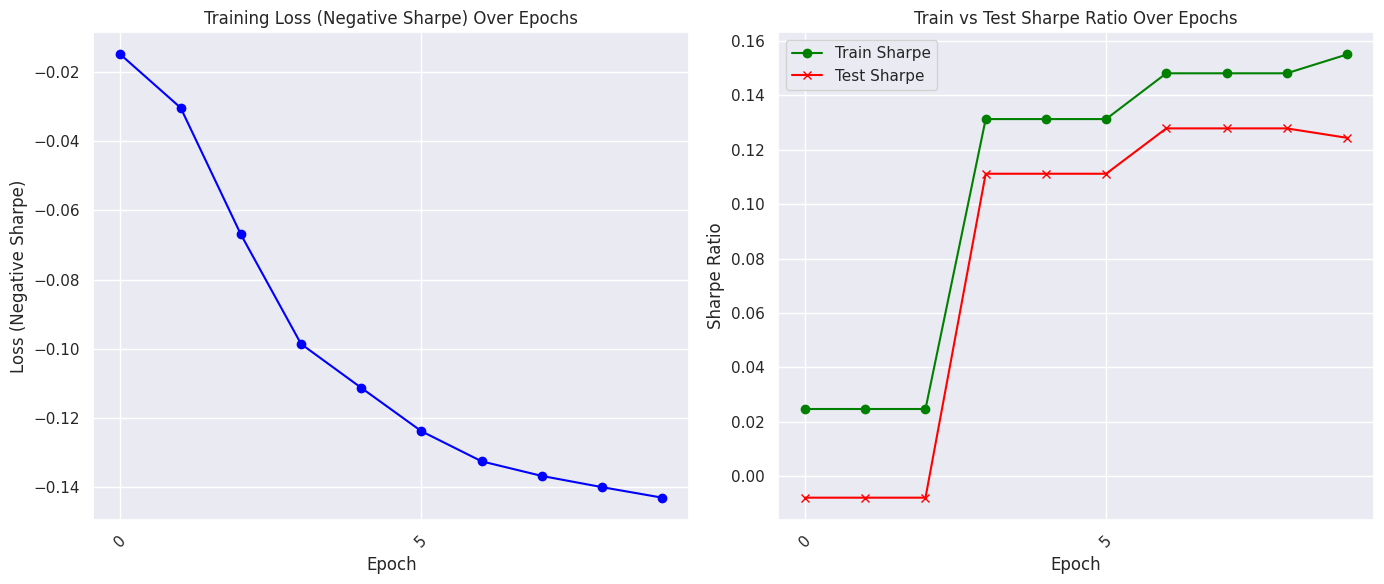

In [15]:
epochs = 10
reload(utils)
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

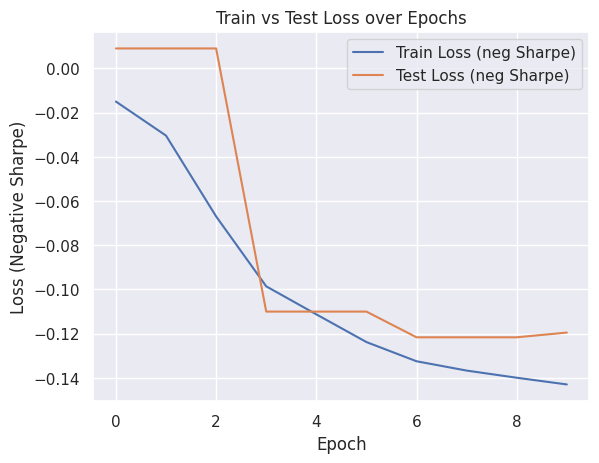

In [16]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

## Do rolling windows increase the Sharpe ratio? 

We've seen just before that using 1 day of lagged returns doesn't lower the Sharpe ratio compared to the case when we use 5 days of lagged returns. 

In [13]:
reload(utils)
# Retrain with only 1 day lagged returns and rolling windows
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()
train_df_2, test_df_2, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['DlyRet', 'sprtrn', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [14]:
train_losses, test_losses, train_sharpes, test_sharpes, strategy_returns = utils.train_DNN(train_df_2, test_df_2, features, cat_features, epochs=10)

Starting training with 435 train batches, 41 test batches


Training:  10%|███▍                              | 1/10 [00:14<02:08, 14.25s/it]

Epoch 1/10, Loss: -0.7534, Train Sharpe: 1.6161, Test Sharpe: 1.5427


Training:  30%|██████████▏                       | 3/10 [00:45<01:49, 15.64s/it]

Epoch 3/10, Loss: -1.8021, Train Sharpe: 2.1108, Test Sharpe: 1.9855


Training:  50%|█████████████████                 | 5/10 [01:18<01:19, 15.93s/it]

Epoch 5/10, Loss: -1.9586, Train Sharpe: 2.1942, Test Sharpe: 2.0548


Training:  70%|███████████████████████▊          | 7/10 [01:50<00:47, 15.86s/it]

Epoch 7/10, Loss: -2.0157, Train Sharpe: 2.1639, Test Sharpe: 2.0205


Training:  90%|██████████████████████████████▌   | 9/10 [02:18<00:14, 14.87s/it]

Epoch 9/10, Loss: -2.0397, Train Sharpe: 2.2293, Test Sharpe: 2.0833


Training: 100%|█████████████████████████████████| 10/10 [02:32<00:00, 15.20s/it]

Epoch 10/10, Loss: -2.0456, Train Sharpe: 2.2695, Test Sharpe: 2.1200
Training completed! Best test Sharpe ratio: 2.1200


In [16]:
train_df_2

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
158482,2000-01-31,15580,786,-0.068182,0.025218,0.000000,0.000000,0.000000,0.000000
158483,2000-01-31,14593,399,0.020910,0.025218,0.000000,0.000000,0.000000,0.000000
158484,2000-01-31,62770,812,0.041045,0.025218,0.000000,0.000000,0.000000,0.000000
158485,2000-01-31,59184,110,0.011236,0.025218,0.000000,0.000000,0.000000,0.000000
158486,2000-01-31,59248,110,0.034667,0.025218,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1048416,2000-06-30,15912,818,-0.013158,0.008465,-0.012987,0.005534,0.004883,0.003759
1048417,2000-06-30,79191,43,0.018018,0.008465,0.037383,-0.007211,-0.003063,-0.005090
1048418,2000-06-30,78671,544,-0.070423,0.008465,0.105058,-0.005470,-0.004885,-0.003756
1048419,2000-06-30,17337,316,0.000000,0.008465,-0.032967,-0.009523,-0.001953,-0.004991


In [17]:
test_df_2

,date,PERMNO,SICCD,DlyRet,sprtrn,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
1048421,2000-07-03,15580,770,0.011494,0.010271,0.000000,0.000000,0.000000,0.0
1048422,2000-07-03,14593,388,0.017900,0.010271,0.000000,0.000000,0.000000,0.0
1048423,2000-07-03,62770,796,0.055556,0.010271,0.000000,0.000000,0.000000,0.0
1048424,2000-07-03,59184,108,0.020921,0.010271,0.000000,0.000000,0.000000,0.0
1048425,2000-07-03,59248,108,0.020661,0.010271,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
1214848,2000-07-31,15912,802,0.013514,0.007705,-0.013333,-0.002595,-0.000048,0.0
1214849,2000-07-31,79191,41,0.013953,0.007705,-0.027149,-0.009405,-0.002302,0.0
1214850,2000-07-31,78671,529,0.012007,0.007705,-0.013536,0.002401,0.005514,0.0
1214851,2000-07-31,17337,307,0.012500,0.007705,0.012658,-0.011365,-0.004435,0.0


In [18]:
strategy_returns

0         0.106061
1         0.110951
2         0.122206
3         0.108459
4         0.108233
            ...   
166427    0.105879
166428    0.110721
166429    0.112424
166430    0.104504
166431    0.096657
Length: 166432, dtype: float32

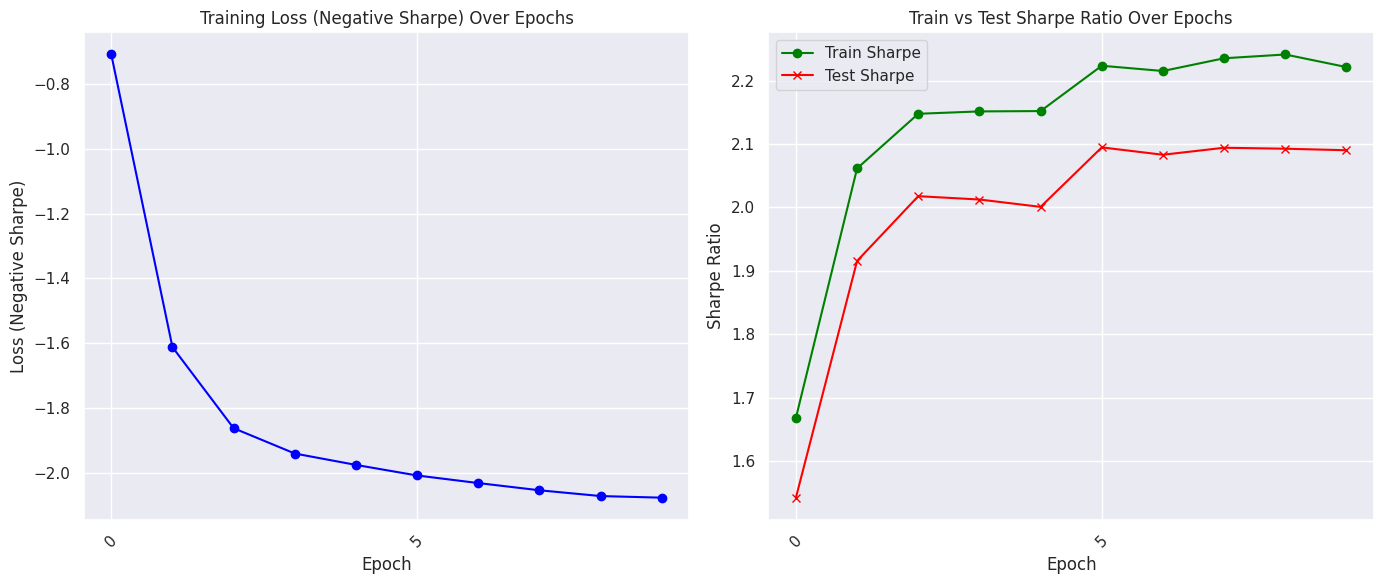

In [9]:
epochs = 10
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

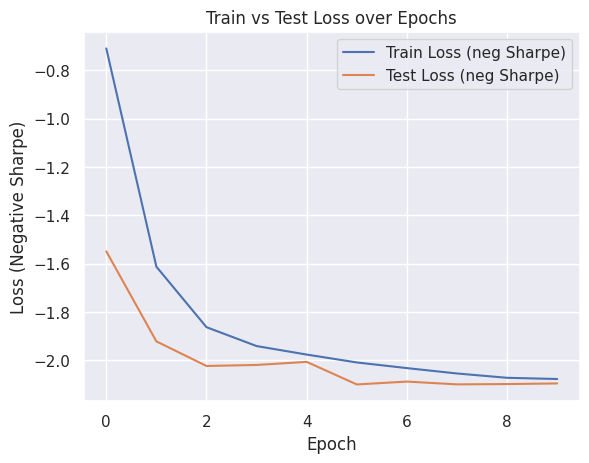

In [10]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

## Incorporate firm characteristics index

Note that rolling windows significantly increase the Sharpe ratio. Therefore, we include them in the training of our DNN. Now that we have fine-tuned the model, let us include the index built from firm characteristics.

In [5]:
index_df = pd.read_csv('Predictors/FirmCharacIndex.csv')
index_df

,Unnamed: 0,date,PERMNO,gvkey,pls_index
0,0,2000-01-31,10025,11903,-3.107469
1,1,2000-01-31,10089,12143,-1.304217
2,2,2000-01-31,10155,12094,-2.892794
3,3,2000-01-31,10182,12171,5.863377
4,4,2000-01-31,10256,12226,-3.608628
...,...,...,...,...,...
520167,520167,2024-12-31,93426,185138,-0.052260
520168,520168,2024-12-31,93427,179583,3.371618
520169,520169,2024-12-31,93429,184500,5.908846
520170,520170,2024-12-31,93434,184259,-4.831854


In [6]:
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month
158482,2000-01-31,5,15580,6320,0,-0.068182,0.025218,2000-01
158483,2000-01-31,7,14593,3573,0,0.020910,0.025218,2000-01
158484,2000-01-31,25,62770,6711,0,0.041045,0.025218,2000-01
158485,2000-01-31,29,59184,2082,0,0.011236,0.025218,2000-01
158486,2000-01-31,33,59248,2082,0,0.034667,0.025218,2000-01
...,...,...,...,...,...,...,...,...
1999995,2000-12-13,16265,86321,6310,0,0.057471,-0.008161,2000-12
1999996,2000-12-13,16266,86324,7370,0,-0.063291,-0.008161,2000-12
1999997,2000-12-13,16267,86337,3660,0,-0.101449,-0.008161,2000-12
1999998,2000-12-13,16268,86339,4899,0,0.009456,-0.008161,2000-12


In [8]:
merged_result = utils.merge_pls_with_asof(daily, index_df)
merged_result

Processing 7849 common PERMNOs...
Processing PERMNO 1/7849
Processing PERMNO 1001/7849
Processing PERMNO 2001/7849
Processing PERMNO 3001/7849
Processing PERMNO 4001/7849
Processing PERMNO 5001/7849
Processing PERMNO 6001/7849
Processing PERMNO 7001/7849
Adding 1253 PERMNOs without PLS data...
Combining results...


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month,pls_index
0,2000-01-31,7953,10001,4920,0,-0.029851,0.025218,2000-01,NaN
1,2000-01-31,7954,10002,6020,0,-0.005236,0.025218,2000-01,NaN
2,2000-01-31,7965,10009,6030,0,-0.004255,0.025218,2000-01,NaN
3,2000-01-31,7969,10012,3670,0,-0.033333,0.025218,2000-01,NaN
4,2000-01-31,1728,10016,3560,0,0.038168,0.025218,2000-01,NaN
...,...,...,...,...,...,...,...,...,...
1841513,2000-12-13,7428,92690,6798,0,0.006993,-0.008161,2000-12,0.710286
1841514,2000-12-13,7407,92807,6020,0,0.014085,-0.008161,2000-12,0.117273
1841515,2000-12-13,7378,92874,3690,0,-0.031746,-0.008161,2000-12,-0.447077
1841516,2000-12-13,7323,92930,3714,0,-0.007634,-0.008161,2000-12,4.626466


In [9]:
utils.check_merge_quality(merged_result, daily)


MERGE QUALITY REPORT
Original daily rows: 1,841,518
Merged rows: 1,841,518
Rows with PLS data: 1,316,468
Rows missing PLS data: 525,050
Coverage: 71.5%
Duplicate (date, PERMNO) pairs: 0

Sample forward fill check:
            date  PERMNO    DlyRet  pls_index
6     2000-01-31   10025  0.025126  -3.107469
8335  2000-02-01   10025  0.019608  -3.107469
16658 2000-02-02   10025  0.030769  -3.107469
24982 2000-02-03   10025  0.000000  -3.107469
33298 2000-02-04   10025  0.007463  -3.107469
41616 2000-02-07   10025 -0.014815  -3.107469
49940 2000-02-08   10025 -0.007519  -3.107469
58251 2000-02-09   10025 -0.030303  -3.107469
66564 2000-02-10   10025 -0.003906  -3.107469
74876 2000-02-11   10025 -0.015686  -3.107469

Date range:
Daily data: 2000-01-31 00:00:00 to 2000-12-13 00:00:00
PLS data: 2000-01-31 00:00:00 to 2000-12-13 00:00:00


In [10]:
test_result = utils.test_merge_logic()
test_result

Processing 1 common PERMNOs...
Processing PERMNO 1/1
Combining results...
Test Results:
         date  PERMNO    DlyRet  pls_index
0  2000-01-01   10001 -0.010362       -1.5
1  2000-01-02   10001  0.026667       -1.5
2  2000-01-03   10001  0.003137       -1.5
3  2000-01-04   10001  0.011178       -1.5
4  2000-01-05   10001  0.002661       -1.5
5  2000-01-06   10001  0.012180       -1.5
6  2000-01-07   10001  0.008479       -1.5
7  2000-01-08   10001  0.000437       -1.5
8  2000-01-09   10001  0.000492       -1.5
9  2000-01-10   10001 -0.000371       -1.5
10 2000-01-11   10001 -0.027041       -1.5
11 2000-01-12   10001 -0.018992       -1.5
12 2000-01-13   10001  0.004174       -1.5
13 2000-01-14   10001  0.007730       -1.5
14 2000-01-15   10001 -0.015885       -2.0
15 2000-01-16   10001  0.030455       -2.0
16 2000-01-17   10001 -0.018866       -2.0
17 2000-01-18   10001 -0.030642       -2.0
18 2000-01-19   10001  0.006501       -2.0
19 2000-01-20   10001 -0.014427       -2.0


,date,PERMNO,DlyRet,pls_index
0,2000-01-01,10001,-0.010362,-1.5
1,2000-01-02,10001,0.026667,-1.5
2,2000-01-03,10001,0.003137,-1.5
3,2000-01-04,10001,0.011178,-1.5
4,2000-01-05,10001,0.002661,-1.5
5,2000-01-06,10001,0.012180,-1.5
6,2000-01-07,10001,0.008479,-1.5
7,2000-01-08,10001,0.000437,-1.5
8,2000-01-09,10001,0.000492,-1.5
9,2000-01-10,10001,-0.000371,-1.5


In [11]:
merged_result = merged_result.fillna(0)
merged_result

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,year_month,pls_index
0,2000-01-31,7953,10001,4920,0,-0.029851,0.025218,2000-01,0.000000
1,2000-01-31,7954,10002,6020,0,-0.005236,0.025218,2000-01,0.000000
2,2000-01-31,7965,10009,6030,0,-0.004255,0.025218,2000-01,0.000000
3,2000-01-31,7969,10012,3670,0,-0.033333,0.025218,2000-01,0.000000
4,2000-01-31,1728,10016,3560,0,0.038168,0.025218,2000-01,0.000000
...,...,...,...,...,...,...,...,...,...
1841513,2000-12-13,7428,92690,6798,0,0.006993,-0.008161,2000-12,0.710286
1841514,2000-12-13,7407,92807,6020,0,0.014085,-0.008161,2000-12,0.117273
1841515,2000-12-13,7378,92874,3690,0,-0.031746,-0.008161,2000-12,-0.447077
1841516,2000-12-13,7323,92930,3714,0,-0.007634,-0.008161,2000-12,4.626466


In [12]:
reload(utils)
# Retrain with only 1 day lagged returns and rolling windows
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (merged_result['year_month'] >= train_start) & (merged_result['year_month'] <= train_end)
test_mask = merged_result['year_month'] == test_month

tr_df = merged_result[train_mask].copy()
te_df = merged_result[test_mask].copy()
train_df_3, test_df_3, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['DlyRet', 'sprtrn', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [13]:
train_df_3

,date,PERMNO,SICCD,DlyRet,sprtrn,pls_index,DlyRet_lag1,DlyRet_roll_10,DlyRet_roll_20,DlyRet_roll_30
0,2000-01-31,10001,589,-0.029851,0.025218,0.000000,0.000661,-0.029851,-0.029851,-0.029851
1,2000-01-31,10002,748,-0.005236,0.025218,0.000000,0.000661,-0.005236,-0.005236,-0.005236
2,2000-01-31,10009,753,-0.004255,0.025218,0.000000,0.000661,-0.004255,-0.004255,-0.004255
3,2000-01-31,10012,442,-0.033333,0.025218,0.000000,0.000661,-0.033333,-0.033333,-0.033333
4,2000-01-31,10016,388,0.038168,0.025218,0.000000,0.000661,0.038168,0.038168,0.038168
...,...,...,...,...,...,...,...,...,...,...
889934,2000-06-30,92690,827,-0.007519,0.008465,0.329130,0.000000,0.000048,0.000148,0.000668
889935,2000-06-30,92807,748,0.055556,0.008465,-0.100565,-0.169231,-0.010919,-0.010063,-0.007521
889936,2000-06-30,92874,450,-0.021277,0.008465,-2.144744,-0.069307,-0.000692,-0.006837,-0.008063
889937,2000-06-30,92930,458,0.002865,0.008465,5.320867,-0.005698,-0.001301,-0.006015,-0.001866


In [14]:
train_losses, test_losses, train_sharpes, test_sharpes = utils.train_DNN(train_df_3, test_df_3, features, cat_features, epochs=10)

Starting training with 435 train batches, 41 test batches


Training:  10%|███▍                              | 1/10 [00:15<02:16, 15.13s/it]

Epoch 1/10, Loss: -0.6483, Train Sharpe: 1.5676, Test Sharpe: 1.4423


Training: 100%|█████████████████████████████████| 10/10 [02:38<00:00, 15.85s/it]

Epoch 10/10, Loss: -2.0836, Train Sharpe: 2.2460, Test Sharpe: 2.1119
Training completed! Best test Sharpe ratio: 2.1576


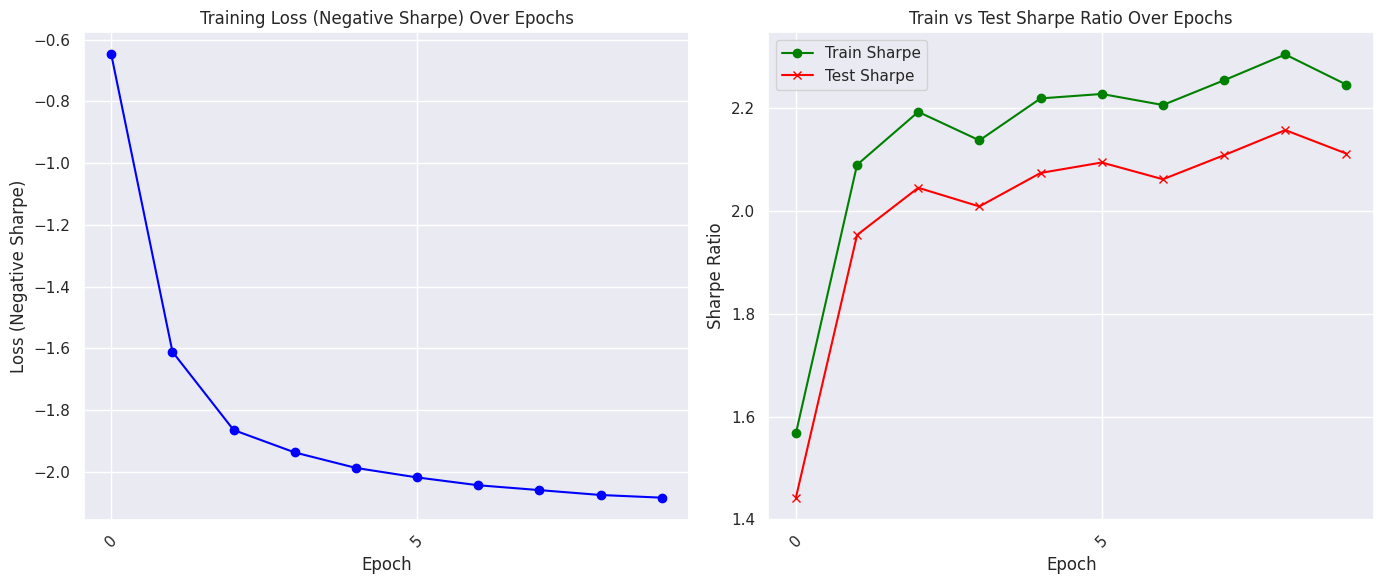

In [15]:
epochs = 10
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

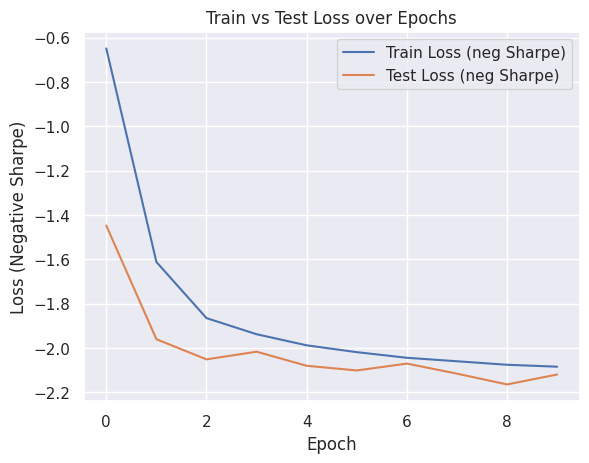

In [16]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)